In [ ]:
# Update sklearn to prevent version mismatches
# !pip install sklearn --upgrade

## Dependencies

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymongo
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from config import mongo_conn

## Load Perfume Data

In [2]:
# Initialize PyMongo to work with MongoDBs
client = pymongo.MongoClient(mongo_conn)
db = client.perfumes_db
perfume_df = pd.DataFrame(list(db.perfume_data.find()))
perfume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   _id           517 non-null    object
 1   name          517 non-null    object
 2   company       517 non-null    object
 3   image         517 non-null    object
 4   for_gender    517 non-null    object
 5   rating        517 non-null    object
 6   number_votes  517 non-null    object
 7   main accords  517 non-null    object
 8   description   517 non-null    object
 9   top notes     517 non-null    object
 10  middle notes  517 non-null    object
 11  base notes    517 non-null    object
 12  longevity     517 non-null    object
 13  sillage       517 non-null    object
 14  gender_vote   517 non-null    object
 15  price value   517 non-null    object
dtypes: object(16)
memory usage: 64.8+ KB


## Preprocess Data

### MultiLabelBinarizer

In [3]:
# convert Notes list to multiple features columns
mlb = MultiLabelBinarizer()

# Top Notes
X_top_notes = mlb.fit_transform(perfume_df["top notes"])
column_names = ["top_note_" + note for note in mlb.classes_]
perfume_df = perfume_df.join(pd.DataFrame(X_top_notes, columns=column_names))

# Middle Notes
X_middle_notes = mlb.fit_transform(perfume_df["middle notes"])
column_names = ["middle_note_" + note for note in mlb.classes_]
perfume_df = perfume_df.join(pd.DataFrame(X_middle_notes, columns=column_names))

# Base notes
X_base_notes = mlb.fit_transform(perfume_df["base notes"])
column_names = ["base_note_" + note for note in mlb.classes_]
perfume_df = perfume_df.join(pd.DataFrame(X_base_notes, columns=column_names))

perfume_df.columns

Index(['_id', 'name', 'company', 'image', 'for_gender', 'rating',
       'number_votes', 'main accords', 'description', 'top notes',
       ...
       'base_note_White Woods', 'base_note_Woodsy Notes',
       'base_note_Woody Notes', 'base_note_Ylang-Ylang', 'base_note_iris',
       'base_note_oak moss', 'base_note_resins', 'base_note_vanilla bean',
       'base_note_vetyver', 'base_note_white honey'],
      dtype='object', length=806)

In [4]:
# replace empty values with 0
perfume_df = perfume_df.fillna(0)
perfume_df.head()

,_id,name,company,image,for_gender,rating,number_votes,main accords,description,top notes,...,base_note_White Woods,base_note_Woodsy Notes,base_note_Woody Notes,base_note_Ylang-Ylang,base_note_iris,base_note_oak moss,base_note_resins,base_note_vanilla bean,base_note_vetyver,base_note_white honey
0,603fbce63bb34da0963ad82a,Angels' Share,By Kilian,https://fimgs.net/mdimg/perfume/375x500.62615.jpg,for women and men,4.31,682,"{'woody': 100.0, 'sweet': 92.6987, 'warm spicy...",Angels' Share by By Kilian is a Oriental Vanil...,[Cognac],...,0,0,0,0,0,0,0,0,0,0
1,603fbce63bb34da0963ad82b,My Way,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.62036.jpg,for women,3.57,1471,"{'white floral': 100.0, 'citrus': 60.4322, 'tu...",My Way by Giorgio Armani is a Floral fragrance...,"[Orange Blossom, Bergamot]",...,0,0,0,0,0,0,0,0,0,0
2,603fbce63bb34da0963ad82c,Libre Intense,Yves Saint Laurent,https://fimgs.net/mdimg/perfume/375x500.62318.jpg,for women,4.02,858,"{'vanilla': 100.0, 'aromatic': 71.4216, 'sweet...",Libre Intense by Yves Saint Laurent is a Orien...,"[Lavender, Mandarin Orange, Bergamot]",...,0,0,0,0,0,0,0,0,0,0
3,603fbce63bb34da0963ad82d,Dior Homme 2020,Christian Dior,https://fimgs.net/mdimg/perfume/375x500.58714.jpg,for men,3.42,1402,"{'woody': 100.0, 'musky': 72.7229, 'amber': 53...",Dior Homme 2020 by Christian Dior is a Woody f...,"[Bergamot, Pink Pepper, elemi]",...,0,0,0,0,0,0,0,0,0,0
4,603fbce63bb34da0963ad82e,Acqua di Giò Profondo,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.59532.jpg,for men,4.03,869,"{'aromatic': 100.0, 'marine': 93.2493, 'citrus...",Acqua di Giò Profondo by Giorgio Armani is a A...,"[Sea Notes, Aquozone, Bergamot, Green Mandarin]",...,0,0,0,0,0,0,0,0,0,0


### X (data) and y (target)

In [5]:
# drop unnecessary columns
X_data = perfume_df.drop(["_id", "name", "company", "image", "for_gender", "rating", "number_votes", "main accords", "description", "top notes", "middle notes", "base notes", "longevity", "sillage", "gender_vote", "price value"], axis=1)

y = perfume_df["for_gender"]

target_names = ["Men", "Women", "Unisex"]

### Create notes_features collection

In [6]:
# find all the notes from perfumes collections
perfumes_features_list = X_data.columns
notes_list = []
for note in perfumes_features_list:
    x = note.rsplit("_", 1)
    notes_list.append(x[1])
notes_list

['African Orange flower',
 'Agarwood (Oud)',
 'Aldehydes',
 'Almond',
 'Almond Blossom',
 'Amalfi Lemon',
 'Amber',
 'Ambrette (Musk Mallow)',
 'Angelica',
 'Anise',
 'Apple',
 'Apricot',
 'Aquozone',
 'Artemisia',
 'Asafoetida',
 'Bamboo',
 'Basil',
 'Bay Leaf',
 'Bellflower',
 'Bergamot',
 'Big Strawberry',
 'Bitter Almond',
 'Bitter Orange',
 'Black Cardamom',
 'Black Currant',
 'Black Pepper',
 'Black Tea',
 'Blackberry',
 'Blood Mandarin',
 'Blood Orange',
 'Brazilian Rosewood',
 'Bulgarian Rose',
 'Cactus',
 'Calabrian bergamot',
 'Candy Apple',
 'Caramel',
 'Caraway',
 'Cardamom',
 'Cardamon',
 'Carrot',
 'Carrot Seeds',
 'Cassia',
 'Cassis',
 'Cedar',
 'Chamomile',
 'Champagne',
 'Cherry',
 'Chili Pepper',
 'Chinotto',
 'Cinnamon',
 'Citruses',
 'Clary Sage',
 'Clementine',
 'Clove',
 'Clover',
 'Cloves',
 'Coconut',
 'Coffee',
 'Cognac',
 'Coriander',
 'Cotton Candy',
 'Cranberry',
 'Cucumber',
 'Cumin',
 'Cyclamen',
 'Cypress',
 'Dewberry',
 'Elemi resin',
 'Exotic Spices',
 

In [7]:
# find unique notes
unique_notes = set(notes_list)
notes_list_df = pd.DataFrame(list(unique_notes), columns=["Note Name"])
notes_list_df

,Note Name
0,Black Vanilla Husk
1,Arum Lily
2,Mate
3,White Flowers
4,Granny Smith apple
...,...
493,Hawthorn
494,Black Tea
495,Pine Tree
496,Freesia


In [8]:
# create a collection for notes features from the perfumes in the collection
notes_features = db.notes_features
# drop collection if it exists
notes_features.drop()
# Creating a collection
notes_features = db.notes_features

In [9]:
# add notes features to mondo db
for jdict in notes_list_df.to_dict(orient='records'):
    notes_features.insert_one(jdict)

In [10]:
# create features with all the notes
note_columns = []
for note in unique_notes:
    note_columns.append("top_note_" + note)
    note_columns.append("middle_note_" + note)
    note_columns.append("base_note_" + note)

In [11]:
#create a dataframe with all features
notes_df = pd.DataFrame(columns=note_columns)
notes_df.loc[len(notes_df)] = 0
notes_df.head()

,top_note_Black Vanilla Husk,middle_note_Black Vanilla Husk,base_note_Black Vanilla Husk,top_note_Arum Lily,middle_note_Arum Lily,base_note_Arum Lily,top_note_Mate,middle_note_Mate,base_note_Mate,top_note_White Flowers,...,base_note_Black Tea,top_note_Pine Tree,middle_note_Pine Tree,base_note_Pine Tree,top_note_Freesia,middle_note_Freesia,base_note_Freesia,top_note_Jasmine Sambac,middle_note_Jasmine Sambac,base_note_Jasmine Sambac
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# merge notes data frame with X to get all features
X = pd.merge(X_data, notes_df, how="left")
X = X.fillna(0)
feature_count = X.shape[1]
X.head()

,top_note_African Orange flower,top_note_Agarwood (Oud),top_note_Aldehydes,top_note_Almond,top_note_Almond Blossom,top_note_Amalfi Lemon,top_note_Amber,top_note_Ambrette (Musk Mallow),top_note_Angelica,top_note_Anise,...,top_note_Watermelon,base_note_Watermelon,top_note_Black Amber,middle_note_Black Amber,top_note_Hawthorn,base_note_Hawthorn,base_note_Black Tea,top_note_Pine Tree,top_note_Jasmine Sambac,base_note_Jasmine Sambac
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create perfume_features collection

In [13]:
# features dataframe
features_df = pd.DataFrame(columns=X.columns)
features_df.loc[len(features_df)] = 0
features_df.head()

,top_note_African Orange flower,top_note_Agarwood (Oud),top_note_Aldehydes,top_note_Almond,top_note_Almond Blossom,top_note_Amalfi Lemon,top_note_Amber,top_note_Ambrette (Musk Mallow),top_note_Angelica,top_note_Anise,...,top_note_Watermelon,base_note_Watermelon,top_note_Black Amber,middle_note_Black Amber,top_note_Hawthorn,base_note_Hawthorn,base_note_Black Tea,top_note_Pine Tree,top_note_Jasmine Sambac,base_note_Jasmine Sambac
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# create a collection name for perfume features
perfume_features = db.perfume_features
# drop collection if it exists
perfume_features.drop()
# Creating a collection
perfume_features = db.perfume_features

In [15]:
# add perfume features to mondo db
for jdict in features_df.to_dict(orient='records'):
    perfume_features.insert_one(jdict)

## Finding Feature Importance

In [ ]:
X.hist(figsize=(15,20))

In [ ]:
# heatmap to figure best features. Features that are more green are highly correlated and thus not a good option
plt.figure(figsize=(15,10))
mask = np.triu(np.ones_like(X.corr(), dtype=np.bool))
heatmap = sns.heatmap(X.corr(), mask=mask, vmin=-1, vmax=1, cmap="BrBG")

In [16]:
# Finding the most important features using RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X, y)

importance_df = pd.DataFrame({"feature": X.columns, 
                              "Importance": round(rf.feature_importances_[0],20)})
importance_df.sort_values("Importance", ascending=False)

,feature,Importance
0,top_note_African Orange flower,0.001104
993,base_note_Dates,0.001104
1002,base_note_Barley,0.001104
1001,top_note_Barley,0.001104
1000,base_note_Apricot,0.001104
...,...,...
495,middle_note_Plastic,0.001104
494,middle_note_Piña Colada,0.001104
493,middle_note_Pitosporum,0.001104
492,middle_note_Pink Pepper,0.001104


## Train and Test data

In [17]:
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
# Create a MinMaxScaler model and fit it to the training data
# X_scaler = MinMaxScaler().fit(X_train)

In [19]:
# Transform the training and testing data using the X_scaler and y_scaler models
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)

## SVC (Linear and RBF)

In [20]:
model = SVC()

# Fit model using GridSearchCV
param_grid = {'C': [5, 20, 50],
              'kernel': ('linear', 'rbf')}
grid = GridSearchCV(model, param_grid, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=5, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. C=5, kernel=linear, score=0.692, total=   0.3s
[CV] C=5, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................. C=5, kernel=linear, score=0.641, total=   0.2s
[CV] C=5, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] .................. C=5, kernel=linear, score=0.584, total=   0.2s
[CV] C=5, kernel=linear ..............................................
[CV] .................. C=5, kernel=linear, score=0.532, total=   0.2s
[CV] C=5, kernel=linear ..............................................
[CV] .................. C=5, kernel=linear, score=0.701, total=   0.2s
[CV] C=5, kernel=rbf .................................................
[CV] ..................... C=5, kernel=rbf, score=0.679, total=   0.3s
[CV] C=5, kernel=rbf .................................................
[CV] ..................... C=5, kernel=rbf, score=0.679, total=   0.3s
[CV] C=5, kernel=rbf .................................................
[CV] ..................... C=5, kernel=rbf, score=0.662, total=   0.3s
[CV] C=5, kernel=rbf .................................................
[CV] ..................... C=5, kernel=rbf, score=0.675, total=   0.3s
[CV] C=5, kernel=rbf .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    8.0s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [5, 20, 50], 'kernel': ('linear', 'rbf')},
             verbose=3)

In [21]:
# Model evaluation metrics
grid_score = grid.score(X_test, y_test)
print('Test Acc: %.3f' % grid_score)
predictions = grid.predict(X_test)
grid_report = classification_report(y_test, predictions)
print(grid_report)
print(grid.best_params_)


Test Acc: 0.569
                   precision    recall  f1-score   support

          for men       0.66      0.57      0.61        37
        for women       0.53      0.90      0.67        51
for women and men       0.58      0.17      0.26        42

         accuracy                           0.57       130
        macro avg       0.59      0.55      0.51       130
     weighted avg       0.59      0.57      0.52       130

{'C': 20, 'kernel': 'rbf'}


### KNearestNeighbor

k: 1, Train/Test Score: 0.987/0.438
k: 3, Train/Test Score: 0.773/0.415
k: 5, Train/Test Score: 0.659/0.392
k: 7, Train/Test Score: 0.610/0.392
k: 9, Train/Test Score: 0.602/0.392
k: 11, Train/Test Score: 0.587/0.392
k: 13, Train/Test Score: 0.584/0.392
k: 15, Train/Test Score: 0.581/0.392


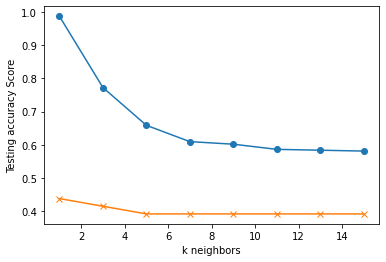

In [22]:
# Instantiate model 2 (KNeighborsClassifier)
train_scores = []
test_scores = []
for k in range(1, 16, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 16, 2), train_scores, marker='o')
plt.plot(range(1, 16, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()


In [23]:
# Model evaluation metrics
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
knn_score = knn.score(X_test, y_test)
print('k=2 Test Acc: %.3f' % knn_score)
predictions = knn.predict(X_test)
knn_report = classification_report(y_test, predictions)
print(knn_report)


k=2 Test Acc: 0.415
                   precision    recall  f1-score   support

          for men       0.75      0.08      0.15        37
        for women       0.41      1.00      0.58        51
for women and men       0.00      0.00      0.00        42

         accuracy                           0.42       130
        macro avg       0.39      0.36      0.24       130
     weighted avg       0.37      0.42      0.27       130



### Decision Tree

In [24]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf_score = clf.score(X_test, y_test)
predictions = clf.predict(X_test)
print('Test Acc: %.3f' % clf_score)
clf_report = classification_report(y_test, predictions,
                            target_names=target_names)
print(clf_report)

Test Acc: 0.492
              precision    recall  f1-score   support

         Men       0.54      0.35      0.43        37
       Women       0.53      0.80      0.64        51
      Unisex       0.36      0.24      0.29        42

    accuracy                           0.49       130
   macro avg       0.47      0.46      0.45       130
weighted avg       0.48      0.49      0.46       130



### RandomForestTree

In [25]:
rf = RandomForestClassifier(n_estimators=100)
rf = rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
predictions = rf.predict(X_test)
print('Test Acc: %.3f' % rf_score)
rf_report = classification_report(y_test, predictions,
                            target_names=target_names)
print(rf_report)

Test Acc: 0.538
              precision    recall  f1-score   support

         Men       0.84      0.43      0.57        37
       Women       0.47      0.98      0.64        51
      Unisex       0.80      0.10      0.17        42

    accuracy                           0.54       130
   macro avg       0.70      0.50      0.46       130
weighted avg       0.68      0.54      0.47       130



### Deep Learning Model

In [26]:
# # Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

In [27]:
# Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [28]:
# Create model and add layers
dlnn = Sequential()
dlnn.add(Dense(units=50, activation='relu', input_dim=feature_count))
dlnn.add(Dense(units=50, activation='relu'))
dlnn.add(Dense(units=50, activation='relu'))
dlnn.add(Dense(units=50, activation='relu'))
dlnn.add(Dense(units=3, activation='softmax'))

In [29]:
# Compile and fit the model
dlnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
dlnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                74750     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 153       
Total params: 82,553
Trainable params: 82,553
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = dlnn.fit(
    X_train,
    y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=100,
    shuffle=True,
    verbose=2
)

Epoch 1/100
13/13 - 1s - loss: 1.0715 - accuracy: 0.5349 - val_loss: 1.0823 - val_accuracy: 0.3923
Epoch 2/100
13/13 - 0s - loss: 0.9798 - accuracy: 0.5814 - val_loss: 1.0913 - val_accuracy: 0.3923
Epoch 3/100
13/13 - 0s - loss: 0.8571 - accuracy: 0.5814 - val_loss: 1.1576 - val_accuracy: 0.3923
Epoch 4/100
13/13 - 0s - loss: 0.7522 - accuracy: 0.5814 - val_loss: 1.0824 - val_accuracy: 0.3923
Epoch 5/100
13/13 - 0s - loss: 0.6347 - accuracy: 0.6253 - val_loss: 1.1080 - val_accuracy: 0.4846
Epoch 6/100
13/13 - 0s - loss: 0.5259 - accuracy: 0.7752 - val_loss: 1.0860 - val_accuracy: 0.5385
Epoch 7/100
13/13 - 0s - loss: 0.4013 - accuracy: 0.8165 - val_loss: 1.1165 - val_accuracy: 0.5692
Epoch 8/100
13/13 - 0s - loss: 0.2846 - accuracy: 0.8863 - val_loss: 1.1573 - val_accuracy: 0.5538
Epoch 9/100
13/13 - 0s - loss: 0.1694 - accuracy: 0.9716 - val_loss: 1.2314 - val_accuracy: 0.5692
Epoch 10/100
13/13 - 0s - loss: 0.0938 - accuracy: 0.9716 - val_loss: 1.5799 - val_accuracy: 0.5692
Epoch 11/

Epoch 83/100
13/13 - 0s - loss: 0.0271 - accuracy: 0.9871 - val_loss: 2.4942 - val_accuracy: 0.6000
Epoch 84/100
13/13 - 0s - loss: 0.0282 - accuracy: 0.9871 - val_loss: 2.5586 - val_accuracy: 0.5769
Epoch 85/100
13/13 - 0s - loss: 0.0264 - accuracy: 0.9871 - val_loss: 2.3696 - val_accuracy: 0.6077
Epoch 86/100
13/13 - 0s - loss: 0.0269 - accuracy: 0.9871 - val_loss: 2.4226 - val_accuracy: 0.6000
Epoch 87/100
13/13 - 0s - loss: 0.0288 - accuracy: 0.9871 - val_loss: 2.5508 - val_accuracy: 0.5769
Epoch 88/100
13/13 - 0s - loss: 0.0267 - accuracy: 0.9871 - val_loss: 2.4593 - val_accuracy: 0.6000
Epoch 89/100
13/13 - 0s - loss: 0.0266 - accuracy: 0.9871 - val_loss: 2.4783 - val_accuracy: 0.6000
Epoch 90/100
13/13 - 0s - loss: 0.0262 - accuracy: 0.9871 - val_loss: 2.4756 - val_accuracy: 0.6000
Epoch 91/100
13/13 - 0s - loss: 0.0272 - accuracy: 0.9871 - val_loss: 2.5038 - val_accuracy: 0.6000
Epoch 92/100
13/13 - 0s - loss: 0.0278 - accuracy: 0.9871 - val_loss: 2.4810 - val_accuracy: 0.6000


In [32]:
model_loss, model_accuracy = dlnn.evaluate(
    X_test, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")


5/5 - 0s - loss: 2.5583 - accuracy: 0.5692
Normal Neural Network - Loss: 2.558258056640625, Accuracy: 0.5692307949066162


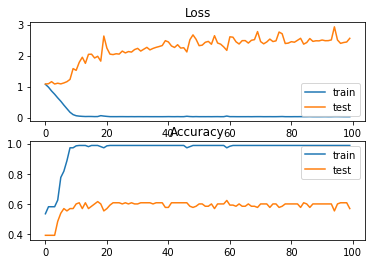

In [33]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

### Save the Best Model

In [34]:
import joblib
final_model = grid.best_estimator_
filename = '../webapp/static/Resources/gender_perfume_model.sav'
joblib.dump(final_model, filename)

# Save scaler
# filename = '../webapp/static/Resources/gender_perfume_model_scaler.sav'
# joblib.dump(X_scaler, filename)


['../webapp/static/Resources/gender_perfume_model.sav']